# Calculations to design the questionnaire

In [1]:
import numpy as np
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import math

### Geometry

In [36]:
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
slope_length = 9/math.sin(angle_slope)
dike_base_slope = total_height/math.tan(angle_slope)
total_base = crest_legth + 2*dike_base_slope
print("Total base width: ", total_base)

Total base width:  57.99999999999999


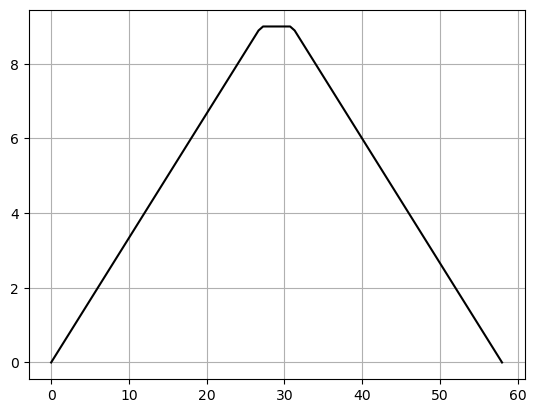

In [37]:
# more precise dike profile

length_arrays = 101
coord_x = np.linspace(0, total_base, length_arrays)

coord_y_dike = np.empty(length_arrays)
for i in range(length_arrays):
    if coord_x[i] < dike_base_slope:
        coord_y_dike[i] = coord_x[i]/slope
    elif coord_x[i] >= dike_base_slope and coord_x[i] <= (dike_base_slope + crest_legth):
        coord_y_dike[i] = total_height
    else:
        coord_y_dike[i] = -(coord_x[i] - (dike_base_slope + crest_legth))/slope + total_height

plt.plot(coord_x, coord_y_dike, color='black')
plt.grid()

### Dupuit parabola - Darcy approx solution: homogeneous dike

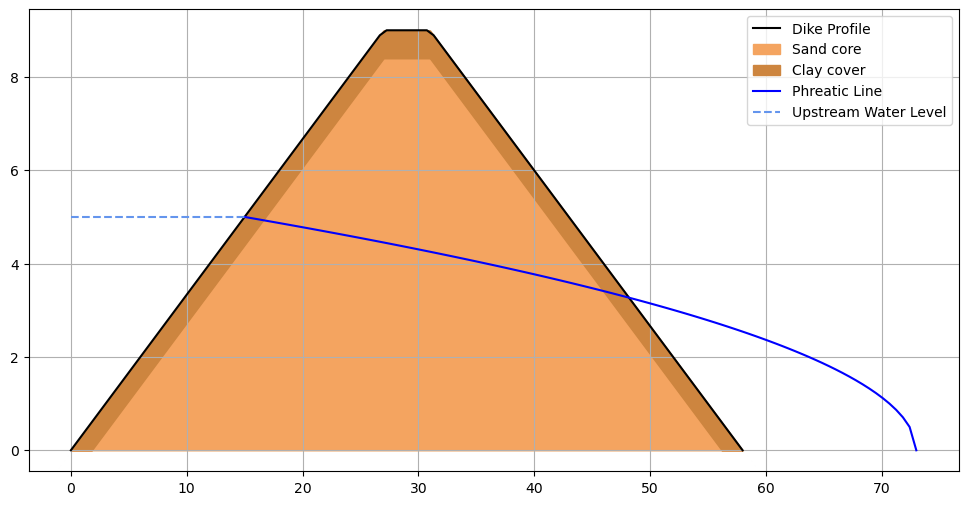

In [63]:
hydraulic_head_up = 5
hydraulic_head_down = 0

# look for the intersection between the water level and the slope
x_entrance_water = slope * hydraulic_head_up

# phreatic levels
phreatic_levels = np.sqrt(hydraulic_head_up**2 - (hydraulic_head_up**2 - hydraulic_head_down**2) * ((coord_x) / total_base))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(coord_x, coord_y_dike, color='black', label='Dike Profile')
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
ax.plot(coord_x + x_entrance_water, phreatic_levels, color='blue', label='Phreatic Line')
ax.plot([0, 15], [hydraulic_head_up, hydraulic_head_up], color='cornflowerblue', linestyle='--', label='Upstream Water Level')
ax.grid()
ax.legend()

Crossing point (x, y):  48.13999999999999 3.2787192621510006


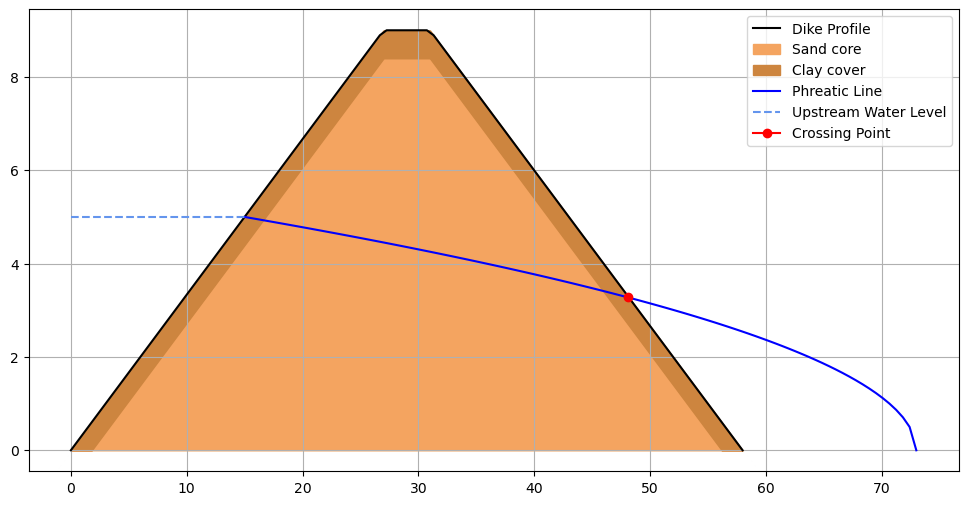

In [64]:
# Find crossing point between phreatic line and dike profile downstream

indices = np.where(coord_x > x_entrance_water)[0]
if indices.size > 0:
    first_index = indices[0]
    # print(first_index, coord_x[first_index]) 
else:
    print("No element greater than threshold.")


for i in range(first_index, length_arrays):
    if coord_y_dike[i] > phreatic_levels[i-first_index]:
        crossing_point_x = coord_x[i]
        crossing_point_y = phreatic_levels[i-first_index]
print("Crossing point (x, y): ", crossing_point_x, crossing_point_y)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(coord_x, coord_y_dike, color='black', label='Dike Profile')
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
ax.plot(coord_x + x_entrance_water, phreatic_levels, color='blue', label='Phreatic Line')
ax.plot([0, 15], [hydraulic_head_up, hydraulic_head_up], color='cornflowerblue', linestyle='--', label='Upstream Water Level')
ax.grid()
ax.legend()
ax.plot(crossing_point_x, crossing_point_y, marker='o', color='red', label='Crossing Point')
ax.legend()

### Two layer section - to revise

Computed steady discharge per unit width q = 5.995e-05 m^2/s


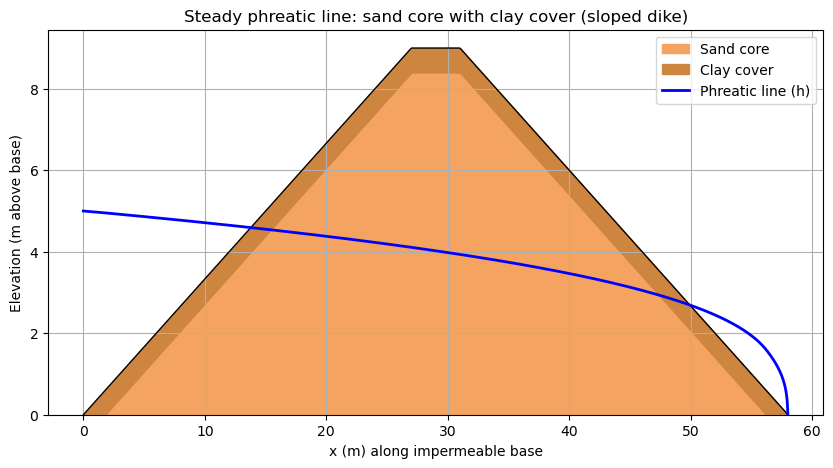

In [61]:
def phreatic_two_material_slope(
    K_clay, K_sand,           # hydraulic conductivities (m/s) for clay cover and sand core
    d_clay_top,               # maximum clay cover thickness (m) measured normal to slope projection
    H_up, H_down,             # upstream and downstream heads above the impermeable base (m)
    L,                        # horizontal projection length of the impermeable base between toes (m)
    H_dike,                   # crest/top elevation of the dike above base (m)
    m_up, m_down,             # slope ratios: horizontal / vertical for upstream and downstream faces
    N=601                     # number of grid points along base for integration (higher -> finer)
):
    """
    Compute steady-state phreatic line for a sloped dike with a clay top layer over a sand core.
    Returns arrays: x (along base), z_top (surface elevation), h (phreatic head above base), q (discharge).
    """
    # --- mesh and basic arrays ------------------------------------------------
    dx = L / (N - 1)                       # horizontal step along the impermeable base
    x = np.linspace(0.0, L, N)             # x positions along the base from upstream toe (0) to downstream toe (L)

    # --- build simplified dike surface geometry z_top(x) ----------------------
    # We construct z_top as a piecewise linear function: upstream slope -> crest (flat) -> downstream slope
    # x_up: horizontal location where upstream slope reaches crest
    # x_down: horizontal location where downstream slope starts descending from crest
    x_up = m_up * H_dike
    x_down = (L - m_up * H_dike - m_down * H_dike) + m_up * H_dike

    # z_top: elevation of the dike surface at each x (above the impermeable base)
    # piecewise:
    #  - x <= x_up : upstream face rising linearly to the crest
    #  - x_up < x < x_down : crest (horizontal plateau at H_dike)
    #  - x >= x_down : downstream face descending linearly to the toe
    z_top = np.piecewise(
        x,
        [x <= x_up, (x > x_up) & (x < x_down), x >= x_down],
        [
            lambda xx: (xx / x_up) * H_dike if x_up > 0 else H_dike,  # upstream slope: linear from 0 at toe to H_dike at crest
            lambda xx: H_dike,                                       # crest: constant elevation
            lambda xx: H_dike - ((xx - x_down) / (L - x_down)) * H_dike if (L - x_down) > 0 else 0.0  # downstream slope
        ]
    )

    # --- function returning effective conductivity given current head h and local surface z_top ----
    def K_of_h(h_val, z_local):
        """
        Determine the effective K * saturated_thickness combination:
        - clay contributes K_clay * min(h, d_clay_local)
        - sand contributes K_sand * max(0, h - d_clay_local)
        This uses the idea that flow is approximately horizontal and the saturated thickness in each
        layer controls how much each K contributes (Dupuit-style, parallel-contribution).
        """
        # Ensure clay thickness doesn't exceed local height (can't have clay thicker than the dike here)
        d_clay_local = np.minimum(d_clay_top, z_local)   # array or scalar depending on input
        # saturated thickness of clay at that point: limited to the clay local thickness
        top_sat = np.minimum(h_val, d_clay_local)
        # saturated thickness of sand under the clay (h minus clay thickness, not negative)
        bottom_sat = np.maximum(h_val - d_clay_local, 0.0)
        # effective K*h term (we will later divide by h when computing dh/dx)
        return K_clay * top_sat + K_sand * bottom_sat

    # --- integrator: given a trial q, march h from x=0 to x=L using dh/dx = - q / (K(h)*h) ---
    def integrate(q):
        """
        Integrate the ODE forward using an explicit Euler step:
          dh = (-q / (K(h)*h)) * dx
        Return the computed h array if successful, or None if an invalid state (h<=0 or K<=0) occurs.
        """
        h = np.empty_like(x)
        h[0] = H_up                        # boundary condition at upstream end: head = H_up
        for i in range(len(x) - 1):
            Ki = K_of_h(h[i], z_top[i])    # effective K*h contribution at current point
            # invalid states (should not happen for well-posed problems): treat as failure
            if Ki <= 0 or h[i] <= 0:
                return None
            # explicit forward Euler for dh/dx
            dh = - q / (Ki * h[i]) * dx    # derived from q = -K(h)*h*(dh/dx)
            h[i+1] = h[i] + dh
            # if next head becomes <= 0 -> invalid physical state (we saturated to zero), treat as failure
            if h[i+1] <= 0:
                return None
        return h

    # --- shoot-and-bracket q: find q so that h(L) matches H_down --------------------------
    # initial bracket estimates for q
    K_est = max(K_clay, K_sand)                         # rough estimate for an upper-permeability
    q_est = (K_est / (2.0 * L)) * (H_up**2 - H_down**2)  # homogeneous-parabola estimate (Dupuit)
    q_lo = 0.0
    q_hi = max(1e-18, q_est * 10.0 + 1e-18)              # start upper bound some factor above estimate

    # expand q_hi until integration yields h(L) <= H_down (or integration fails -> treat as too large)
    # we want a bracket where h(q_lo, L) > H_down and h(q_hi, L) <= H_down
    h_lo = integrate(q_lo)
    h_lo_end = h_lo[-1] if (h_lo is not None) else -np.inf
    for _ in range(60):
        h_hi = integrate(q_hi)
        h_hi_end = -np.inf if (h_hi is None) else h_hi[-1]
        if (h_lo_end > H_down) and (h_hi_end <= H_down):
            break
        q_hi *= 2.0
    else:
        # failed to bracket - either parameters are inconsistent or resolution needs tuning
        raise RuntimeError("Unable to bracket q. Try different parameters or increase N.")

    # --- bisection on q to find q giving h(L) = H_down -------------------------------------
    max_iter = 120
    tol = 1e-8
    for _ in range(max_iter):
        q_mid = 0.5 * (q_lo + q_hi)
        h_mid = integrate(q_mid)
        if h_mid is None:
            # integration failure for this q_mid means q_mid is too large (head collapsed), reduce high bound
            q_hi = q_mid
            continue
        err = h_mid[-1] - H_down
        if abs(err) < tol:
            # found q that makes h(L) sufficiently close to H_down
            return x, z_top, h_mid, q_mid
        # if h(L) > H_down we need more flux (larger q) to drop head more quickly -> move lower bound up
        if h_mid[-1] > H_down:
            q_lo = q_mid
        else:
            q_hi = q_mid

    # if we exit the loop without converging
    raise RuntimeError("Shooting did not converge to required tolerance.")

# ---------------- Example usage (change these to your real parameters) ---------------------
K_clay = 1e-7    # m/s (low permeability clay cover)
K_sand = 1e-4    # m/s (higher permeability sand core)
d_clay_top = 0.6 # m clay thickness (max)
H_up = 5       # upstream head above base (m)
H_down = 0     # downstream head above base (m)
L = total_base         # horizontal base length between toes (m)
H_dike = total_height     # crest elevation above base (m)
m_up = 3.0       # upstream slope: 3 H : 1 V
m_down = 3.0     # downstream slope: 2 H : 1 V

# run solver
x, z_top, h, q = phreatic_two_material_slope(
    K_clay, K_sand, d_clay_top, H_up, H_down, L, H_dike, m_up, m_down, N=1001
)

print(f"Computed steady discharge per unit width q = {q:.3e} m^2/s")

# ---------------- Corrected plotting so layers don't overlap or go negative ----------------
# compute local clay thickness (can't exceed local z_top)
d_clay_local = np.minimum(d_clay_top, z_top)   # clay thickness at every x (array)
z_sand_top = z_top - d_clay_local             # top of sand core (bottom of clay)

# Ensure sand top is non-negative (numerical safety)
z_sand_top = np.maximum(z_sand_top, 0.0)

plt.figure(figsize=(10,5))
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
# dike surface line
plt.plot(x, z_top, 'k-', lw=1)
# phreatic line (heads are above base already)
plt.plot(x, h, 'b-', lw=2, label='Phreatic line (h)')
plt.xlabel('x (m) along impermeable base')
plt.ylabel('Elevation (m above base)')
plt.title('Steady phreatic line: sand core with clay cover (sloped dike)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

In [ ]:
def phreatic_two_material_slope(
    K_clay, K_sand,           # hydraulic conductivities (m/s) for clay cover and sand core
    d_clay_top,               # maximum clay cover thickness (m) measured normal to slope projection
    H_up, H_down,             # upstream and downstream heads above the impermeable base (m)
    L,                        # horizontal projection length of the impermeable base between toes (m)
    H_dike,                   # crest/top elevation of the dike above base (m)
    m                           # slope ratios: symmetric faces
    N=601                     # number of grid points along base for integration (higher -> finer)
):
    """
    Compute steady-state phreatic line for a sloped dike with a clay top layer over a sand core.
    Returns arrays: x (along base), z_top (surface elevation), h (phreatic head above base), q (discharge).
    """
    # --- mesh and basic arrays ------------------------------------------------
    dx = L / (N - 1)                       # horizontal step along the impermeable base
    x = np.linspace(0.0, L, N)             # x positions along the base from upstream toe (0) to downstream toe (L)

    # --- build simplified dike surface geometry z_top(x) ----------------------
    # We construct z_top as a piecewise linear function: upstream slope -> crest (flat) -> downstream slope
    # x_up: horizontal location where upstream slope reaches crest
    # x_down: horizontal location where downstream slope starts descending from crest
    x_up = m * H_dike
    x_down = (L - m * H_dike - m * H_dike) + m * H_dike
    angle_slope = math.atan(1/m)

    # z_top: elevation of the dike surface at each x (above the impermeable base)
    # piecewise:
    #  - x <= x_up : upstream face rising linearly to the crest
    #  - x_up < x < x_down : crest (horizontal plateau at H_dike)
    #  - x >= x_down : downstream face descending linearly to the toe
    z_top = np.piecewise(
        x,
        [x <= x_up, (x > x_up) & (x < x_down), x >= x_down],
        [
            lambda xx: (xx / x_up) * H_dike if x_up > 0 else H_dike,  # upstream slope: linear from 0 at toe to H_dike at crest
            lambda xx: H_dike,                                       # crest: constant elevation
            lambda xx: H_dike - ((xx - x_down) / (L - x_down)) * H_dike if (L - x_down) > 0 else 0.0  # downstream slope
        ]
    )

    # --- function returning effective conductivity given current head h and local surface z_top ----
    def K_of_h(h_val, z_local, angle_slope, x_up, x_down, x_local):
        """
        Determine the effective K * saturated_thickness combination:
        This uses the idea that flow is approximately horizontal and the saturated thickness in each
        layer controls how much each K contributes (Dupuit-style, parallel-contribution).
        """
        # compute local clay thickness considering slope
        if (x_local <= x_up) or (x_local >= x_down):
            clay_thickness = d_clay_top/math.cos(angle_slope)
        else: 
            clay_thickness = d_clay_top

        if h_val > (z_local-clay_thickness):
            top_sat = np.minimum(clay_thickness, h_val - (z_local - clay_thickness))   # array or scalar depending on input
        else:
            top_sat = 0
        
        # saturated thickness of sand under the clay
        bottom_sat = np.maximum(h_val - d_clay_local, 0.0)
        
        # effective K*h term (we will later divide by h when computing dh/dx)
        return K_clay * top_sat + K_sand * bottom_sat

    # --- integrator: given a trial q, march h from x=0 to x=L using dh/dx = - q / (K(h)*h) ---
    def integrate(q):
        """
        Integrate the ODE forward using an explicit Euler step:
          dh = (-q / (K(h)*h)) * dx
        Return the computed h array if successful, or None if an invalid state (h<=0 or K<=0) occurs.
        """
        h = np.empty_like(x)
        h[0] = H_up                        # boundary condition at upstream end: head = H_up
        for i in range(len(x) - 1):
            Ki = K_of_h(h[i], z_top[i])    # effective K*h contribution at current point
            # invalid states (should not happen for well-posed problems): treat as failure
            if Ki <= 0 or h[i] <= 0:
                return None
            # explicit forward Euler for dh/dx
            dh = - q / (Ki * h[i]) * dx    # derived from q = -K(h)*h*(dh/dx)
            h[i+1] = h[i] + dh
            # if next head becomes <= 0 -> invalid physical state (we saturated to zero), treat as failure
            if h[i+1] <= 0:
                return None
        return h

    # --- shoot-and-bracket q: find q so that h(L) matches H_down --------------------------
    # initial bracket estimates for q
    K_est = max(K_clay, K_sand)                         # rough estimate for an upper-permeability
    q_est = (K_est / (2.0 * L)) * (H_up**2 - H_down**2)  # homogeneous-parabola estimate (Dupuit)
    q_lo = 0.0
    q_hi = max(1e-18, q_est * 10.0 + 1e-18)              # start upper bound some factor above estimate

    # expand q_hi until integration yields h(L) <= H_down (or integration fails -> treat as too large)
    # we want a bracket where h(q_lo, L) > H_down and h(q_hi, L) <= H_down
    h_lo = integrate(q_lo)
    h_lo_end = h_lo[-1] if (h_lo is not None) else -np.inf
    for _ in range(60):
        h_hi = integrate(q_hi)
        h_hi_end = -np.inf if (h_hi is None) else h_hi[-1]
        if (h_lo_end > H_down) and (h_hi_end <= H_down):
            break
        q_hi *= 2.0
    else:
        # failed to bracket - either parameters are inconsistent or resolution needs tuning
        raise RuntimeError("Unable to bracket q. Try different parameters or increase N.")

    # --- bisection on q to find q giving h(L) = H_down -------------------------------------
    max_iter = 120
    tol = 1e-8
    for _ in range(max_iter):
        q_mid = 0.5 * (q_lo + q_hi)
        h_mid = integrate(q_mid)
        if h_mid is None:
            # integration failure for this q_mid means q_mid is too large (head collapsed), reduce high bound
            q_hi = q_mid
            continue
        err = h_mid[-1] - H_down
        if abs(err) < tol:
            # found q that makes h(L) sufficiently close to H_down
            return x, z_top, h_mid, q_mid
        # if h(L) > H_down we need more flux (larger q) to drop head more quickly -> move lower bound up
        if h_mid[-1] > H_down:
            q_lo = q_mid
        else:
            q_hi = q_mid

    # if we exit the loop without converging
    raise RuntimeError("Shooting did not converge to required tolerance.")

# ---------------- Example usage (change these to your real parameters) ---------------------
K_clay = 1e-7    # m/s (low permeability clay cover)
K_sand = 1e-4    # m/s (higher permeability sand core)
d_clay_top = 0.6 # m clay thickness (max)
H_up = 5       # upstream head above base (m)
H_down = 0     # downstream head above base (m)
L = total_base         # horizontal base length between toes (m)
H_dike = total_height     # crest elevation above base (m)
m_up = 3.0       # upstream slope: 3 H : 1 V
m_down = 3.0     # downstream slope: 2 H : 1 V

# run solver
x, z_top, h, q = phreatic_two_material_slope(
    K_clay, K_sand, d_clay_top, H_up, H_down, L, H_dike, m_up, m_down, N=1001
)

print(f"Computed steady discharge per unit width q = {q:.3e} m^2/s")

# ---------------- Corrected plotting so layers don't overlap or go negative ----------------
# compute local clay thickness (can't exceed local z_top)
d_clay_local = np.minimum(d_clay_top, z_top)   # clay thickness at every x (array)
z_sand_top = z_top - d_clay_local             # top of sand core (bottom of clay)

# Ensure sand top is non-negative (numerical safety)
z_sand_top = np.maximum(z_sand_top, 0.0)

plt.figure(figsize=(10,5))
# sand: fill from base (0) up to top of sand
plt.fill_between(x, 0.0, z_sand_top, color='sandybrown', label='Sand core')
# clay: fill from top of sand up to surface
plt.fill_between(x, z_sand_top, z_top, color='peru', label='Clay cover')
# dike surface line
plt.plot(x, z_top, 'k-', lw=1)
# phreatic line (heads are above base already)
plt.plot(x, h, 'b-', lw=2, label='Phreatic line (h)')
plt.xlabel('x (m) along impermeable base')
plt.ylabel('Elevation (m above base)')
plt.title('Steady phreatic line: sand core with clay cover (sloped dike)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

End of notebook.